### Recommendation using Word2Vec
By Kruti Thukral (012586041)

With large-scale heterogenous data being generated on a daily basis,there is a need to improvise the conventional recommenation systems. I wanted to explore the application of models proven in NLP in recommendation systems. Below is an implementation of book recommendations using word embeddings. 

Reference paper:
M. Ozsoy, "From Word Embeddings to Item Recommendation," arXiv.Org, 2016

Reference code snippet: 
https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

Problem statement: Given a book, the system should recommend other books to the reader.

1.   
To solve the above problem , I will use reading pattern of all the readers and create word embeddings. These embeddings will help in recommending other books.
2. Above problem can be also solved using content-based recommendation and finding similar book using cosine similarity.
3. Compare both the solutions using evaluation metrics to conclude which alogrithm performs better







Import needed libraries

In [0]:
import sys
import pandas as pd
import gdown
import os
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

Mount google drive to access the pre-processed integrated dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load integrated dataset

In [0]:
df=pd.read_csv('/content/drive/Shared drives/Project_256/Complete_Data_new.gz', compression="gzip")

Our integrated dataset is around 7.3 million

In [0]:
len(df)

7347630

In [0]:
df.head()

,Unnamed: 0,text_reviews_count,country_code,language_code,popular_shelves,is_ebook,average_rating,description,authors,publication_year,book_id,ratings_count,title,title_without_series,user_id,review_id,is_read,rating,date_added,date_updated,read_at,started_at,review_text,n_votes,n_comments,authorid
0,0,1,US,NaN,"[{'count': '228', 'name': 'to-read'}, {'count'...",True,4.12,Lillian Ann Cross is forced to live the worst ...,"[{'author_id': '8551671', 'role': ''}]",NaN,25742454,1,The Switchblade Mamma,The Switchblade Mamma,f1830550c10246b9924d03fbb7858a3b,cadab2ad2d162553b3b6b2a5884ec0ea,True,5,Wed Jun 15 16:38:58 -0700 2016,Wed Jun 15 16:38:59 -0700 2016,Wed Jun 15 16:38:59 -0700 2016,NaN,Raw and amazing \n This book is unlike any oth...,0.0,0.0,['8551671']
1,1,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,12c0f4c16b6cad9f595fc99f3dcb49d4,60158dd333055f54053506e590cc1291,True,4,Mon May 09 05:03:09 -0700 2016,Tue May 10 07:07:51 -0700 2016,Mon May 09 00:00:00 -0700 2016,NaN,NaN,NaN,NaN,['3274315']
2,2,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,bdd5da2d7c778880e20573efd4df888a,a4b605858b28feff2cb14018839950d1,True,5,Sat Jan 21 07:18:46 -0800 2017,Sun Feb 05 06:35:09 -0800 2017,Sun Feb 05 06:35:09 -0800 2017,Sat Jan 21 00:00:00 -0800 2017,NaN,NaN,NaN,['3274315']
3,3,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,15b0c6dbe18c5e493b39aaa30cb6d2b8,111f1d4941d77877558c4a4ffff87239,False,0,Mon Apr 24 08:28:14 -0700 2017,Mon Apr 24 08:28:20 -0700 2017,NaN,NaN,NaN,NaN,NaN,['3274315']
4,4,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,dc9f898ef44e9d38d8eb92a7bde1341d,831e2005e78a56b1f90b26877eeea1f3,True,2,Sun Aug 28 16:15:38 -0700 2016,Thu Sep 08 16:51:22 -0700 2016,Thu Sep 08 16:51:22 -0700 2016,NaN,NaN,NaN,NaN,['3274315']


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7347630 entries, 0 to 7347629
Data columns (total 26 columns):
Unnamed: 0              int64
text_reviews_count      int64
country_code            object
language_code           object
popular_shelves         object
is_ebook                bool
average_rating          float64
description             object
authors                 object
publication_year        float64
book_id                 int64
ratings_count           int64
title                   object
title_without_series    object
user_id                 object
review_id               object
is_read                 bool
rating                  int64
date_added              object
date_updated            object
read_at                 object
started_at              object
review_text             object
n_votes                 float64
n_comments              float64
authorid                object
dtypes: bool(2), float64(4), int64(5), object(15)
memory usage: 1.3+ GB


Check for columns having null nalues


In [0]:
df.isnull().sum()

Unnamed: 0                    0
text_reviews_count            0
country_code                  0
language_code           1149907
popular_shelves               0
is_ebook                      0
average_rating                0
description              529032
authors                       0
publication_year         829880
book_id                       0
ratings_count                 0
title                         0
title_without_series          0
user_id                       0
review_id                     0
is_read                       0
rating                        0
date_added                    0
date_updated                  0
read_at                 5086379
started_at              5856311
review_text             6805615
n_votes                 6805292
n_comments              6805292
authorid                      0
dtype: int64

Data visualization for distribution of users across ratings   

In [0]:
shelve_user = df['user_id'].value_counts().value_counts().reset_index().sort_values('index').values
read_user = df['user_id'].loc[df['is_read']>0].value_counts().value_counts().reset_index().sort_values('index').values
rate_user = df['user_id'].loc[df['rating']>0].value_counts().value_counts().reset_index().sort_values('index').values

shelve_book = df['book_id'].value_counts().value_counts().reset_index().sort_values('index').values
read_book = df['book_id'].loc[df['is_read']>0].value_counts().value_counts().reset_index().sort_values('index').values
rate_book = df['book_id'].loc[df['rating']>0].value_counts().value_counts().reset_index().sort_values('index').values


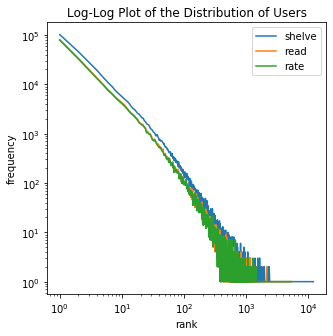

In [0]:
plt.figure(figsize=(5,5))
plt.loglog(shelve_user[:,0], shelve_user[:,1], label='shelve')
plt.loglog(read_user[:,0], read_user[:,1], label='read')
plt.loglog(rate_user[:,0], rate_user[:,1], label='rate')
#plt.loglog(review_user[:,0], review_user[:,1], label='review')
plt.xlabel('rank')
plt.ylabel('frequency')
plt.title('Log-Log Plot of the Distribution of Users')
plt.legend(loc='upper right')

Data visualization for distribution of books across ratings

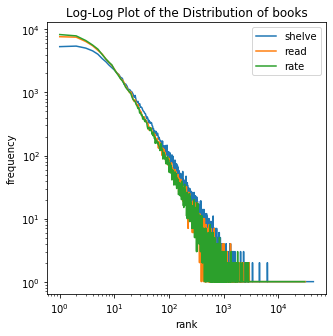

In [0]:
plt.figure(figsize=(5,5))
plt.loglog(shelve_book[:,0], shelve_book[:,1], label='shelve')
plt.loglog(read_book[:,0], read_book[:,1], label='read')
plt.loglog(rate_book[:,0], rate_book[:,1], label='rate')

plt.xlabel('rank')
plt.ylabel('frequency')
plt.title('Log-Log Plot of the Distribution of books')
plt.legend(loc='upper right')

Drop features not required for the algorithm

In [0]:
data = df[['user_id', 'book_id', 'date_added', 'title']]
data['book_id']= data['book_id'].astype(str)

In [0]:
data.head()

,user_id,book_id,date_added,title
0,f1830550c10246b9924d03fbb7858a3b,25742454,Wed Jun 15 16:38:58 -0700 2016,The Switchblade Mamma
1,12c0f4c16b6cad9f595fc99f3dcb49d4,30128855,Mon May 09 05:03:09 -0700 2016,Cruelle
2,bdd5da2d7c778880e20573efd4df888a,30128855,Sat Jan 21 07:18:46 -0800 2017,Cruelle
3,15b0c6dbe18c5e493b39aaa30cb6d2b8,30128855,Mon Apr 24 08:28:14 -0700 2017,Cruelle
4,dc9f898ef44e9d38d8eb92a7bde1341d,30128855,Sun Aug 28 16:15:38 -0700 2016,Cruelle


Change format of date column to the required format. We need to sort the date later so that the reading history is in ascending order (by date) for each user


In [0]:
import dateutil
data['date_added'] = data['date_added'].apply(dateutil.parser.parse, ignoretz=True)

In [0]:
data.head()

,user_id,book_id,date_added,title
0,f1830550c10246b9924d03fbb7858a3b,25742454,2016-06-15 16:38:58,The Switchblade Mamma
1,12c0f4c16b6cad9f595fc99f3dcb49d4,30128855,2016-05-09 05:03:09,Cruelle
2,bdd5da2d7c778880e20573efd4df888a,30128855,2017-01-21 07:18:46,Cruelle
3,15b0c6dbe18c5e493b39aaa30cb6d2b8,30128855,2017-04-24 08:28:14,Cruelle
4,dc9f898ef44e9d38d8eb92a7bde1341d,30128855,2016-08-28 16:15:38,Cruelle


In [0]:
# check number of unique users 
users = data["user_id"].unique().tolist()
len(users)

342415

We have to split the users in training and validation set. 
90% users will be in training set and 10% in validation set. We cannot split the same user across training and validation as that will change the reading history. Maintaining a sequence of the reading history is crucial for our algorithm and thus training and validation set has distint users

In [0]:
# Compute 90% of the readers that would be in training set 
import random
random.shuffle(users)

# extract 90% of customer ID's
user_train = [users[i] for i in range(round(0.9*len(users)))]
len(user_train)


308174

In [0]:
# split data into train and validation set
train_df = data[data['user_id'].isin(user_train)]
print(train_df)


                                  user_id  ...         title
1        12c0f4c16b6cad9f595fc99f3dcb49d4  ...       Cruelle
2        bdd5da2d7c778880e20573efd4df888a  ...       Cruelle
3        15b0c6dbe18c5e493b39aaa30cb6d2b8  ...       Cruelle
4        dc9f898ef44e9d38d8eb92a7bde1341d  ...       Cruelle
5        4867af4dbac45448491c46b43363f240  ...       Cruelle
...                                   ...  ...           ...
7347625  40cad038063319b661615c26cb2b3c18  ...  Dead Endings
7347626  8bcf48afa72aba125b53749c2e7c9ad4  ...  Dead Endings
7347627  699b0a72e1e07abc5a6d2736b109928f  ...  Dead Endings
7347628  262b53abd0d2da2e8d02c362fdeaf4f5  ...  Dead Endings
7347629  5fa1e552e5aeb58c6d97614c51bfb1d4  ...  Dead Endings

[6614048 rows x 4 columns]


Create validation set

In [0]:
validation_df = data[~data['user_id'].isin(user_train)]
print(validation_df)

                                  user_id  ...                                              title
0        f1830550c10246b9924d03fbb7858a3b  ...                              The Switchblade Mamma
21       e9903d02b505a62f2cde84bb2be193de  ...  Captain America: Winter Soldier (The Ultimate ...
80       dca7474250b87bafd7f64ae665d8e91d  ...                                 Crossed, Volume 15
86       e14642210b7a70b21eeeb6bf07f9ddd7  ...                                 Crossed, Volume 15
94       3d204395a256d16acdeaf65c4494721f  ...  Crossed + One Hundred, Volume 2 (Crossed +100 #2)
...                                   ...  ...                                                ...
7347564  501bfd45d783bdf291f6d151f97ef1f8  ...               Doctor Who: Free Comic Book Day 2016
7347567  a082a944b2371f88f9ab07583665e902  ...               Doctor Who: Free Comic Book Day 2016
7347572  9626a0c095fd5d1a44605fbc689414f9  ...               Doctor Who: Free Comic Book Day 2016
7347583  b03bc0660a0

Test some grouping functions which are to be used later




In [0]:
#train_df.groupby(['user_id']).groups.keys()

In [0]:
# train_df[train_df.user_id == 'bd53fcba9dbb9ca1d2ca1551b44007e7'	]

In [0]:
#train_df.groupby('user_id')['book_id'].count()

Group By user id and then sort by date

In [0]:
grouped = train_df.groupby(['user_id'],as_index=False).apply(lambda x: x.sort_values(["date_added"], ascending = True))


In [0]:
grouped.head(100)

user_id  ...                                              title
0  2374691  00004584d524ec468619e81b176cc991  ...                              Fruits Basket, Vol. 1
   5526315  00004584d524ec468619e81b176cc991  ...       Kare Kano: His and Her Circumstances, Vol. 1
   3147545  00004584d524ec468619e81b176cc991  ...       Kare Kano: His and Her Circumstances, Vol. 2
   6245556  00004584d524ec468619e81b176cc991  ...      Kare Kano: His and Her Circumstances, Vol. 12
   3147164  00004584d524ec468619e81b176cc991  ...       Kare Kano: His and Her Circumstances, Vol. 3
...                                      ...  ...                                                ...
12 5173904  000387b0e3d77b6dcc36a66d5cc27347  ...   Uglies: Shay's Story (Uglies: Graphic Novel, #1)
13 5917842  0003a8eb2989503d03ad7ca701898a48  ...  Naruto, Vol. 01: The Tests of the Ninja (Narut...
   4130763  0003a8eb2989503d03ad7ca701898a48  ...       Death Note, Vol. 1: Boredom (Death Note, #1)
   4829754  0003a8eb2989503d03ad7ca701898a48  ...                          Bakuman: Complete Box Set
   430293   0003a8eb2989503d03ad7ca701898a48  ...                               Si Juki: Komik Strip

[100 rows x 4 columns]

Group by Book Id to get reading history of all users

In [0]:
reading_history = grouped.groupby('user_id')['book_id'].apply(list).reset_index()



In [0]:
reading_list = reading_history['book_id'].tolist()
print(reading_list[2])

['472331', '25103', '21330', '5805', '25100', '15719', '1270615', '7746259', '342445', '43808', '30288', '1799011', '6052502', '7278189']


Create word embeddings using Word2Vec Model by providing a list of reading history of all users

In [0]:

# train word2vec model
model = Word2Vec(window = 5, sg = 1,
                 # for negative sampling
                 min_count=1, size=150, iter=10)

model.build_vocab(reading_list, progress_per=200)

model.train(reading_list, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(65704825, 66140480)

In [0]:
# save word2vec model
model.save("word2vec_2.model")

In [0]:
model.init_sims(replace=True)

In [0]:
print(model)

Word2Vec(vocab=88787, size=150, alpha=0.025)


In [0]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(88787, 150)

Data visualization for the generated word enbeddings

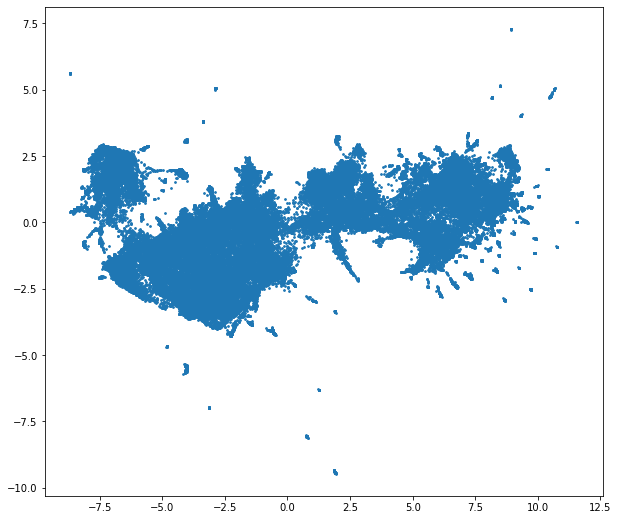

In [0]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [0]:
books = df[['book_id', 'title']]
books['book_id']= books['book_id'].astype(str)
# remove duplicates
books.drop_duplicates(inplace=True, subset='book_id', keep="last")

# create product-ID and product-description dictionary
books_dict = books.groupby('book_id')['title'].apply(list).to_dict()

Utility to find similar books

In [0]:
def similar_products(v, n = 20):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (books_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

Pass a book id to see the title of the book

In [0]:
books_dict['25233412']

['Lumberjanes #6']

Check similar books to Lumberjanes #6

In [0]:
similar_products(model['25233412'])

[('Lumberjanes #7', 0.9251632690429688),
 ('Lumberjanes #5', 0.9046493172645569),
 ('Lumberjanes #8', 0.8667962551116943),
 ('Lumberjanes #4', 0.7952837347984314),
 ('Lumberjanes #10', 0.7737115621566772),
 ('Lumberjanes #9', 0.7717084884643555),
 ('Lumberjanes #11', 0.7332926988601685),
 ('Lumberjanes #13', 0.71864253282547),
 ('Lumberjanes #3', 0.7185992002487183),
 ("Archie: Rockin' the World", 0.7136366963386536),
 ('Lumberjanes #12', 0.7125082015991211),
 ('Lumberjanes #2', 0.6973168849945068),
 ('Eye of Newt #1', 0.6961299777030945),
 ('Adventure Time Summer 2013 Special #1', 0.6825842261314392),
 ('Page by Paige', 0.6762638092041016),
 ('Superman Vol. 5: Under Fire (The New 52)', 0.6760036945343018),
 ('Lumberjanes #1', 0.6738401055335999),
 ('X-Men Origins: Nightcrawler #1 (X-Men Origins (2008-2010))',
  0.6685709953308105),
 ('Rocket Raccoon #3', 0.667353093624115),
 ('Star Wars: In Shadow of Yavin: Vol. 2', 0.6635650396347046)]

### **Wow it did recommend other books in the "lumberjanes" series ! This algorithm seems to work !**

Lets check results for another book

In [0]:
books_dict['22731045']

['Adventure Time: Banana Guard Academy #1']

Lets check book similar to above book

In [0]:
similar_products(model['22731045'])

[('Adventure Time: Banana Guard Academy #2', 0.9058193564414978),
 ('Adventure Time: Banana Guard Academy #3', 0.8677616715431213),
 ('Adventure Time: Banana Guard Academy #4', 0.815670907497406),
 ('Abigail and the Snowman #2', 0.7955044507980347),
 ('The Woods #9', 0.7905305624008179),
 ('The Woods #11', 0.7862293720245361),
 ('Penny Dora and the Wishing Box #3', 0.784365177154541),
 ('Adventure Time: Banana Guard Academy #5', 0.7829160094261169),
 ('Abigail and the Snowman #3', 0.7815525531768799),
 ('The Woods #10', 0.7770017981529236),
 ('Abigail and the Snowman #1', 0.776556670665741),
 ('Oddly Normal #8', 0.7754290699958801),
 ('Abigail and the Snowman #4', 0.7745276689529419),
 ('The Woods #4', 0.7734706401824951),
 ('Munchkin #4', 0.7726688385009766),
 ('Munchkin #3', 0.7720385193824768),
 ('The Woods #3', 0.7706050872802734),
 ('Afterlife With Archie #7: Betty R.I.P. Chapter 2 - Dear Diary... (Afterlife With Archie Series)',
  0.7658134698867798),
 ('Oddly Normal #2', 0.76506

### It  was able to recommend other books in the series and other books that were recommended also seem to be on similar lines. Visually this algorithm seems to be working, but we can only tell when we have some evaluation metrics . Metrics such as Precision@k, hit rate , coverage and nDCG can be used as per the paper. Below is my attempt to calculate the Precision by using one book for a user and trying to see whether the recommended book are is his reading list (on the basis of one book). This approach did not work. Couple of other approaches that I can think of are as below 


*   Instead of considering one book, consider half of the reading list to see whether the predictions (on the basis of half the list) have an intersection with the other half
*   Instead of having distint users in train and test set, have users distributed across both. Using reading history of user in train set, come up with predictions and check whether they have intersection with the books in the test set for the user 

Evaluation of such a system seems to be more evolved and needs elaborate research to come up with the best strategy and implementation. 



In [0]:
reading_history_validation = validation_df.groupby('user_id')['book_id'].apply(list).reset_index()


In [116]:
unique_users = validation_df["user_id"].unique().tolist()
len(unique_users)

34241

In [115]:
reading_history_validation

,user_id,book_id
0,000bcfc25a4ec41e7ec3de82bd1ae3d0,"[15195, 9517, 9516, 744615, 7904429, 9446190, ..."
1,000efb30c5236d7437c3cdf4bf3e4dc7,"[64581, 37261, 85578, 114967, 402252, 12918119..."
2,000f09a363afe420bdbc2dfcf522029c,[6348419]
3,001570676f7943d9c445d2209ccbabfb,"[282358, 229151, 271199, 1404466, 287388, 1605..."
4,0016a992215a18dc242672e9d19d2b84,[472331]
...,...,...
34236,fff785db3b7a0755573779d6279009de,"[7941986, 11871319, 18594409, 11566956, 65977,..."
34237,fff85dc76c1d78fb7938c48f69d2e14f,[7306986]
34238,fffa8bc2ca9727638006dd9b6c5adc8a,[16992]
34239,fffcca008c7770bc559e43b2edf24a6d,[14498]


In [117]:
# get thge reading history of the user and consider one book of the list to compute recommendations
book_list = reading_history_validation.head(5)['book_id']
book_id = book_list[4][0]
other_history = book_list[0]
print(book_id)
print(other_history)

472331
['15195', '9517', '9516', '744615', '7904429', '9446190', '8477057', '6407014', '16992', '769712', '62953', '1870771', '5805', '11566956', '20442885', '13138831', '11480909', '1782543', '1136465', '118944', '25179', '5989573', '2396554', '7965835', '4070095', '6435893', '29800', '29801', '29802', '46640', '6871845']


In [0]:
def similar_products_for_evaluation(v, n = 30):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        print(j[0])
        new_ms.append(j[0])
        
    return new_ms

In [119]:
lst1 = similar_products_for_evaluation(book_id)
print(lst1)

13835792
4599958
23553407
1404587
3119183
12703004
18517011
29064099
14510172
27804794
2757778
182176
2601016
1990504
7359765
7296850
1813000
32941063
23542
6387938
13001718
14799464
804507
331831
1472606
7278915
8579650
219531
6468238
16098684
['13835792', '4599958', '23553407', '1404587', '3119183', '12703004', '18517011', '29064099', '14510172', '27804794', '2757778', '182176', '2601016', '1990504', '7359765', '7296850', '1813000', '32941063', '23542', '6387938', '13001718', '14799464', '804507', '331831', '1472606', '7278915', '8579650', '219531', '6468238', '16098684']


In [120]:
print(book_id)

472331


In [121]:
# check whether there is an intersection between recommended books and actual reading history
print(lst1)
print(other_history)
common_elements = set(lst1).intersection(set(other_history))
common_elements


['13835792', '4599958', '23553407', '1404587', '3119183', '12703004', '18517011', '29064099', '14510172', '27804794', '2757778', '182176', '2601016', '1990504', '7359765', '7296850', '1813000', '32941063', '23542', '6387938', '13001718', '14799464', '804507', '331831', '1472606', '7278915', '8579650', '219531', '6468238', '16098684']
['15195', '9517', '9516', '744615', '7904429', '9446190', '8477057', '6407014', '16992', '769712', '62953', '1870771', '5805', '11566956', '20442885', '13138831', '11480909', '1782543', '1136465', '118944', '25179', '5989573', '2396554', '7965835', '4070095', '6435893', '29800', '29801', '29802', '46640', '6871845']


set()

```
Above we saw good recommendations using word2Vec. I also wanted to recommend using content-based recommendation using item matrix of books.I reached as far as creating item matrix for the books. However, due to time constraints could not complete the implementation of cosine similarity. Below is the code for computing the item matric of books using one hot encoding
#Load book dataset
fn = '/content/drive/Shared drives/Project_256/goodreads_books_comics_graphic.json.gz'
books = pd.read_json(fn, lines=True, compression='gzip')
books.tail()
books.info()
#Replace null values with nan
import numpy as np
books.replace('', np.nan, inplace=True)
books

books.info()

#Replace null values with nan

import numpy as np
books.replace('', np.nan, inplace=True)
books

#One hot encode categorical columns

books = pd.get_dummies(books, dummy_na=False, columns=['country_code', 'language_code'])

books

authors=books['authors']

#Convert authors to needed format

author_list=[]
for i in authors:
    author=[]
    for j in i:
      author.append(j['author_id'])
    author_list.append(author)

df_with_author_list=books

df_with_author_list

df_with_author_list['authorid'] = author_list

df_with_author_list



#One hot encode author list

one_hot_encode_author = pd.get_dummies(df_with_author_list.authorid.apply(pd.Series), prefix="", prefix_sep="")

df_with_author_list.join(one_hot_encode_author)

df_with_author_list.to_csv('/content/drive/Shared drives/Project_256/books_item_matrix.csv')
```